In [168]:
import numpy as np
import pandas as pd
import nltk
import re
import pickle
import tensorflow as tf
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [170]:
df=pd.read_csv('train.txt',header=None,names=["Comments","Emotion"],sep=";")
df.head()

Comments  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

In [172]:
df["Length"]=[len(i) for i  in df['Comments']]
df

Comments  Emotion  Length
0                                i didnt feel humiliated  sadness      23
1      i can go from feeling so hopeless to so damned...  sadness     108
2       im grabbing a minute to post i feel greedy wrong    anger      48
3      i am ever feeling nostalgic about the fireplac...     love      92
4                                   i am feeling grouchy    anger      20
...                                                  ...      ...     ...
15995  i just had a very brief time in the beanbag an...  sadness     101
15996  i am now turning and i feel pathetic that i am...  sadness     102
15997                     i feel strong and good overall      joy      30
15998  i feel like this was such a rude comment and i...    anger      59
15999  i know a lot but i feel so stupid because i ca...  sadness      62

[16000 rows x 3 columns]

In [174]:
df['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

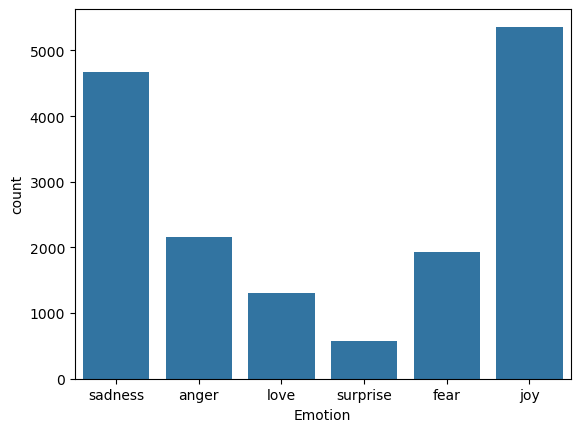

In [176]:
sns.countplot(df,x=df["Emotion"])
plt.show()

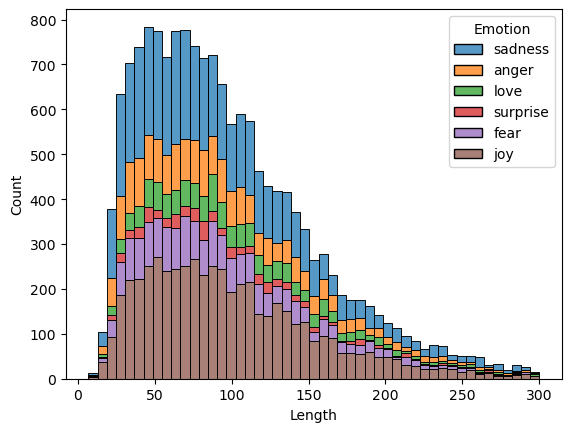

In [178]:
sns.histplot(df, x='Length', hue='Emotion', multiple='stack')
plt.show()


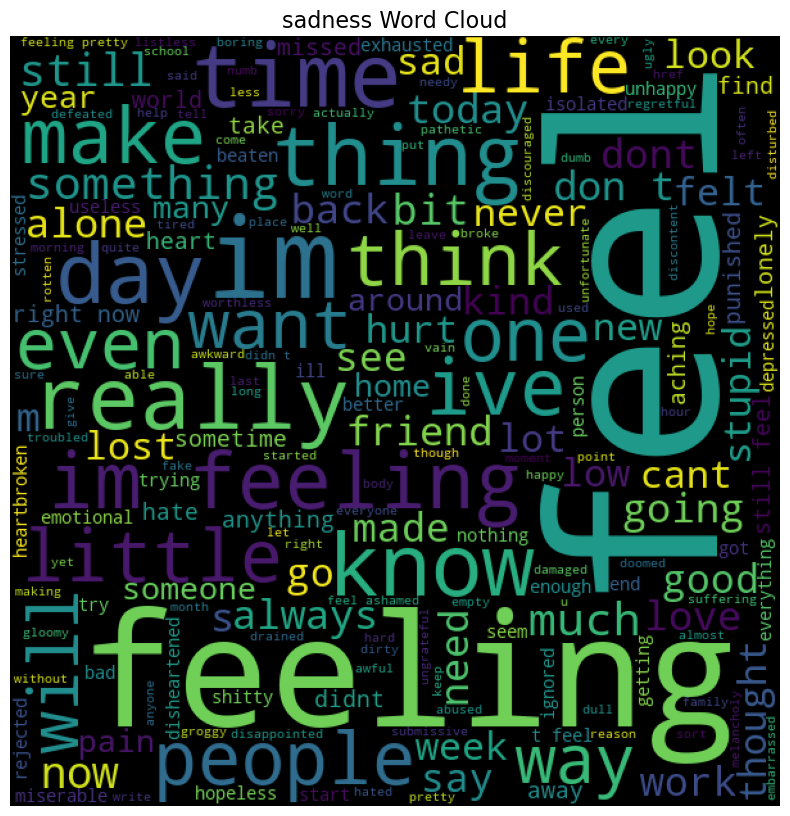

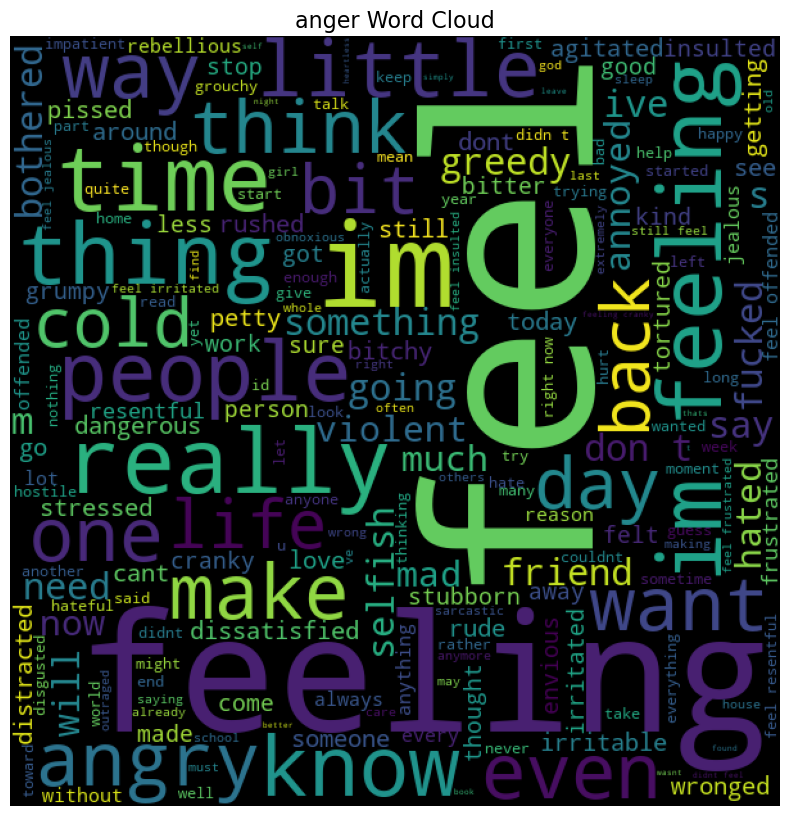

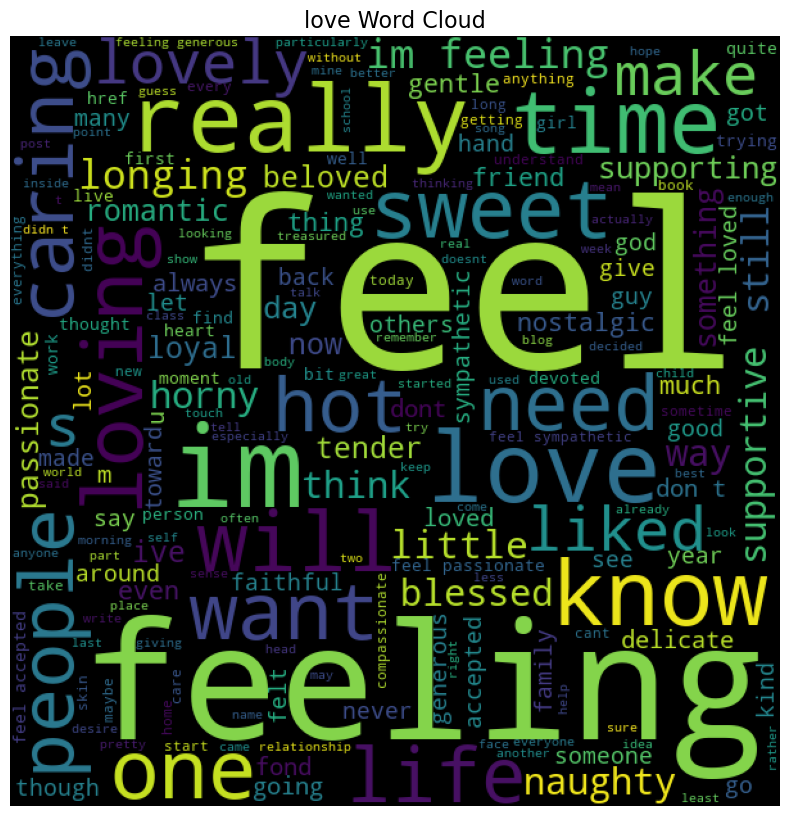

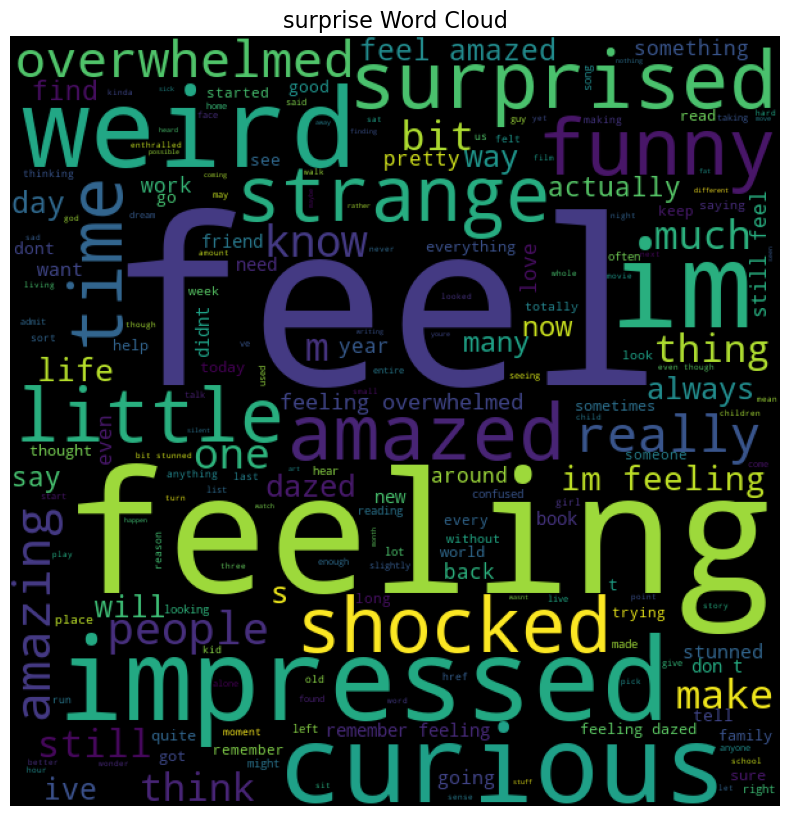

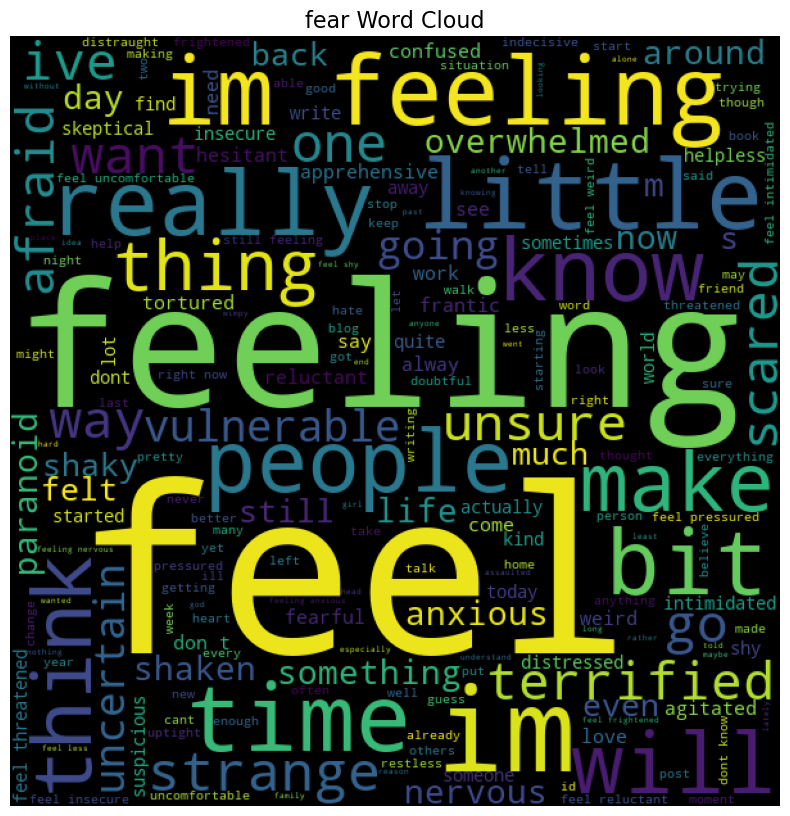

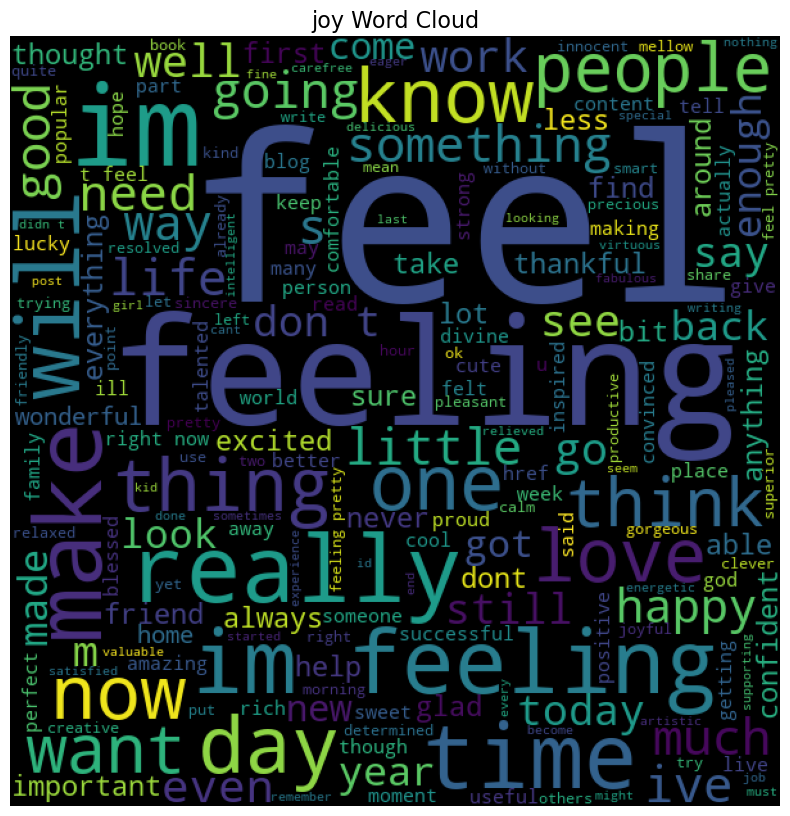

In [180]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = df['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in df.loc[df['Emotion'] == emotion,'Comments']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

### Preprocessing

In [182]:
le=LabelEncoder()
df['Emotion']=le.fit_transform(df['Emotion'])
df

Comments  Emotion  Length
0                                i didnt feel humiliated        4      23
1      i can go from feeling so hopeless to so damned...        4     108
2       im grabbing a minute to post i feel greedy wrong        0      48
3      i am ever feeling nostalgic about the fireplac...        3      92
4                                   i am feeling grouchy        0      20
...                                                  ...      ...     ...
15995  i just had a very brief time in the beanbag an...        4     101
15996  i am now turning and i feel pathetic that i am...        4     102
15997                     i feel strong and good overall        2      30
15998  i feel like this was such a rude comment and i...        0      59
15999  i know a lot but i feel so stupid because i ca...        4      62

[16000 rows x 3 columns]

In [ ]:
#joy 2
#sadness 4    
#anger 0       
#fear   1     
#love    3    
#surprise 5    

In [216]:
df['Emotion'].value_counts()

Emotion
2    5362
4    4666
0    2159
1    1937
3    1304
5     572
Name: count, dtype: int64

In [185]:
stopwords = set(nltk.corpus.stopwords.words('english'))


In [187]:
vocab_size=11000
max_length=max([len(i) for i in df["Comments"]])
max_length

300

In [189]:
def clean_text(df, column, vocab_size, max_length):
    cleaned_col = []
    Stemmer = PorterStemmer()
    for text in df[column]:
        text = re.sub('[^a-zA-Z]', ' ', text).lower()
        words = text.split()
        words = [Stemmer.stem(word) for word in words if word not in stopwords]
        cleaned_text = ' '.join(words)
        cleaned_col.append(cleaned_text)

    one_hot_words = [one_hot(input_text=text, n=vocab_size) for text in cleaned_col]
    padded_sequences = pad_sequences(sequences=one_hot_words, maxlen=max_length, padding='pre')
    
    return padded_sequences
    

X_train=clean_text(df, 'Comments', vocab_size, max_length)

In [190]:
X_train

array([[    0,     0,     0, ...,  9466, 10516, 10723],
       [    0,     0,     0, ...,   932,  7622,  7294],
       [    0,     0,     0, ..., 10516,  1942,  6756],
       ...,
       [    0,     0,     0, ...,  3390,  3737,  2235],
       [    0,     0,     0, ...,  8230,  5444,  1416],
       [    0,     0,     0, ..., 10516,  8801,  7423]])

In [191]:
y_train=to_categorical(df["Emotion"])

In [195]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

### Model

In [197]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=150, input_length=max_length),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='sigmoid'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

C:\Users\daniy\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [199]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])


In [201]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 240ms/step - accuracy: 0.3014 - loss: 1.6530
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.6404 - loss: 1.0267
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 246ms/step - accuracy: 0.8570 - loss: 0.4536
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 247ms/step - accuracy: 0.9233 - loss: 0.2522
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step - accuracy: 0.9430 - loss: 0.1806
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.9547 - loss: 0.1374
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 257ms/step - accuracy: 0.9622 - loss: 0.1114
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.9687 - loss: 0.0890
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.9724 - loss: 0.0820
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.9755 - loss: 0.0698


In [202]:
def sentence_clean(sentence):
    # Remove non-alphabet characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', sentence).lower()
    # Split into words
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Join words back into a string
    cleaned_text = ' '.join(words)
    # One-hot encode the text
    one_hot_word = one_hot(input_text=cleaned_text, n=11000)
    # Pad the sequences
    pad = pad_sequences(sequences=[one_hot_word], maxlen=300, padding='pre')
    return pad

sentences = [
    "I feel strong and good overall",
    "I'm grabbing a minute to post I feel greedy wrong",
    "He was speechless when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like I'm all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "I am ever feeling nostalgic about the fireplace I will know that it is still on the property",
    "I am feeling grouchy",
    "He hates you"
]

for sen in sentences:
    print(sen)
    sentence = sentence_clean(sen)
    prediction = model.predict(sentence)
    result = le.inverse_transform([np.argmax(prediction)])
    prob = np.max(prediction)
    print(result[0], ":", prob * 100)

I feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
joy : 99.9123752117157
I'm grabbing a minute to post I feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
anger : 98.18719029426575
He was speechless when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
anger : 52.8935432434082
This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
joy : 30.0565242767334
I feel like I'm all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
love : 97.58623242378235
He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
joy : 92.90156364440918
You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
joy : 65.76546430587769
I am ever feeling nostalgic about the fireplace I will know that it is still on the property
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
anger : 61.1457884311676
I am feeling grouchy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
anger : 93.3914303779602
He hates you
1/1 ━━━━━━━━━━━━━━━━

In [203]:
vocab_info = {'vocab_size': 11000, 'max_len': 300}
model.save('emotion_model.h5')
pickle.dump(le,open('labelEncoder.pkl','wb'))
pickle.dump(vocab_info,open('vocab_info.pkl','wb'))

### app

In [ ]:
#joy 2
#sadness 4    
#anger 0       
#fear   1     
#love    3    
#surprise 5    

In [240]:
def emotion_decoder(emotion):
    message=[]
    if emotion==1:
        message.append('Fear')
    elif emotion==2:
        message.append('Joy')
    elif emotion==3:
        message.append('Love')
    elif emotion==4:
        message.append('Sadness')
    elif emotion==5:
        message.append('Suprise')
    else:
        message.append('Anger')
    
    return(message[0])
    
def sentence_clean(sentence):
    text = re.sub('[^a-zA-Z]', ' ', sentence).lower()
    words = text.split()
    words = [word for word in words if word not in stopwords]
    cleaned_text = ' '.join(words)
    one_hot_word = one_hot(input_text=cleaned_text, n=11000)
    pad = pad_sequences(sequences=[one_hot_word], maxlen=300, padding='pre')
    return pad

# Prediction function
def paredict_result(sentence):
    sentence = sentence_clean(sentence)
    prediction = model.predict(sentence)
    result = np.argmax(prediction)
    result = emotion_decoder(result)
    prob = np.max(prediction)
    return result, prob
    


sen = "I feel strong "
result,prob = paredict_result(sen)
print(result,prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Joy 0.9967997


In [234]:
def emotion_decoder(emotion):
    message=[]
    if emotion==1:
        message.append('Fear')
    elif emotion==2:
        message.append('Joy')
    elif emotion==3:
        message.append('Love')
    elif emotion==4:
        message.append('Sadness')
    elif emotion==5:
        message.append('Suprise')
    else:
        message.append('Anger')
    return(message[0])
    

In [238]:
print(emotion_decoder(4))

sadness
